In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

Load the stock data

In [58]:
symbol = 'AAPL'
aapl = yf.download(symbol, start='2020-01-01', end='2024-12-31')
aapl = aapl[['Open', 'High', 'Low', 'Close', 'Volume']]


aapl.index = pd.DatetimeIndex(aapl.index)
aapl = aapl.asfreq('B')  # 'B' = Business Days
aapl = aapl.fillna(method='ffill')
print(aapl.head())


/tmp/ipython-input-288357952.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl = yf.download(symbol, start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed

Price            Open       High        Low      Close       Volume
Ticker           AAPL       AAPL       AAPL       AAPL         AAPL
Date                                                               
2020-01-02  71.627077  72.681274  71.373203  72.620827  135480400.0
2020-01-03  71.847118  72.676447  71.689957  71.914818  146322800.0
2020-01-06  71.034724  72.526549  70.783263  72.487862  118387200.0
2020-01-07  72.497529  72.753823  71.926915  72.146942  108872000.0
2020-01-08  71.849540  73.609752  71.849540  73.307518  132079200.0



/tmp/ipython-input-288357952.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aapl = aapl.fillna(method='ffill')


In [59]:
print("Shape:", aapl.shape)
print("\nData types:\n", aapl.dtypes)
print("\nMissing values:\n", aapl.isnull().sum())
print("\nSummary statistics:\n", aapl.describe())

Shape: (1303, 5)

Data types:
 Price   Ticker
Open    AAPL      float64
High    AAPL      float64
Low     AAPL      float64
Close   AAPL      float64
Volume  AAPL      float64
dtype: object

Missing values:
 Price   Ticker
Open    AAPL      0
High    AAPL      0
Low     AAPL      0
Close   AAPL      0
Volume  AAPL      0
dtype: int64

Summary statistics:
 Price          Open         High          Low        Close        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1303.000000  1303.000000  1303.000000  1303.000000  1.303000e+03
mean     151.831054   153.501797   150.287779   151.987040  9.008123e+07
std       41.913108    42.104763    41.747707    41.964471  5.313797e+07
min       55.277748    55.379539    51.528419    54.378586  2.323470e+07
25%      126.288218   128.160595   124.962368   126.872932  5.517695e+07
50%      150.443542   152.292427   148.733440   150.623489  7.613830e+07
75%      176.621873   178.243167   175.203045   176.928413

In [60]:
aapl.columns = aapl.columns.get_level_values(0)
print(aapl.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object', name='Price')


EDA & Visualization

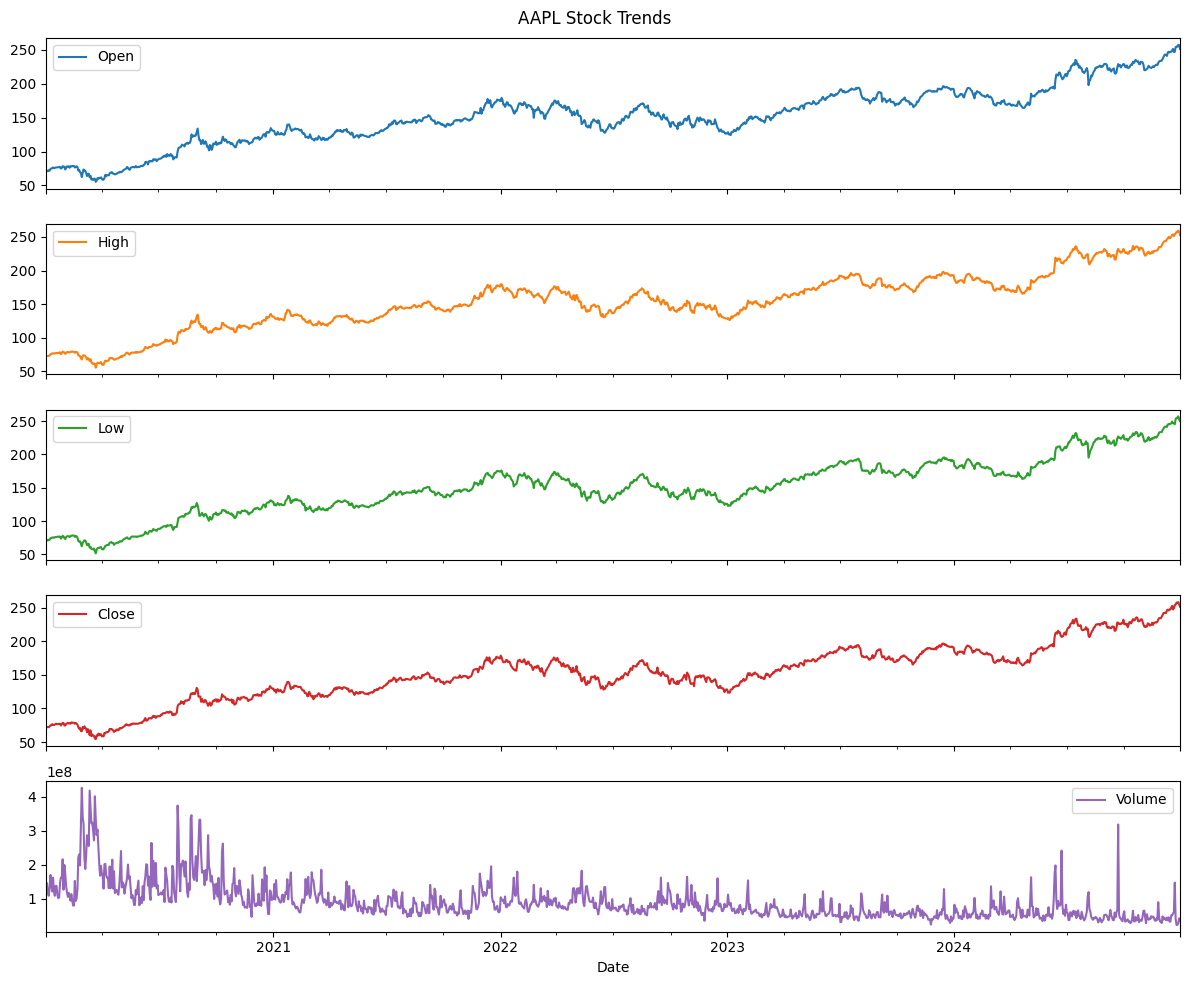

In [61]:
aapl.plot(subplots=True, figsize=(12, 10), title=f'{symbol} Stock Trends')
plt.tight_layout()
plt.show()


In [63]:
correlation_matrix = aapl[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
print(correlation_matrix)

Price       Open      High       Low     Close    Volume
Price                                                   
Open    1.000000  0.999409  0.999393  0.998672 -0.633470
High    0.999409  1.000000  0.999247  0.999400 -0.625538
Low     0.999393  0.999247  1.000000  0.999390 -0.642204
Close   0.998672  0.999400  0.999390  1.000000 -0.633977
Volume -0.633470 -0.625538 -0.642204 -0.633977  1.000000


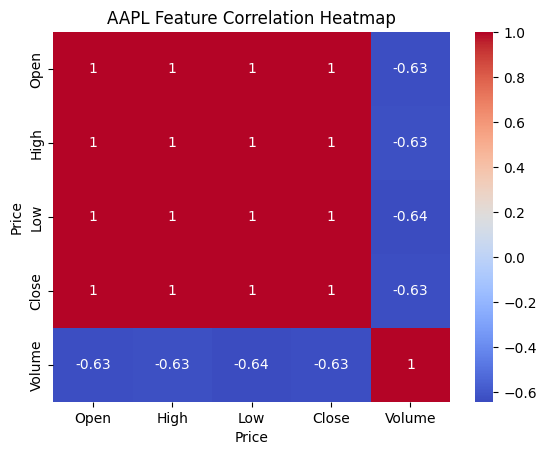

In [64]:
sns.heatmap(aapl.corr(), annot=True, cmap='coolwarm')
plt.title(f'{symbol} Feature Correlation Heatmap')
plt.show()


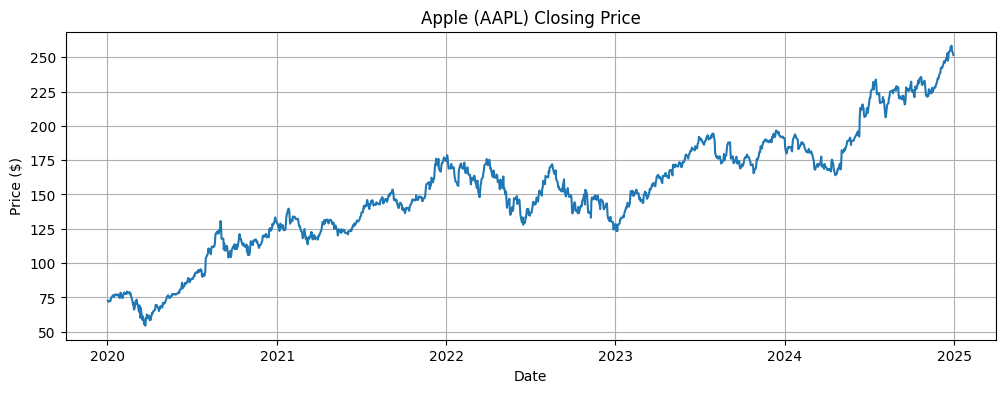

In [71]:
plt.figure(figsize=(12, 4))
plt.plot(aapl['Close'])
plt.title("Apple (AAPL) Closing Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.show()


ARIMA MODEL

Before applying ARIMA or SARIMA, we need to ensure your data is stationary (constant mean/variance over time)

In [72]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(aapl['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

#If p-value < 0.05: ✅ Data is stationary
#here as the p-value is !<0.05 so it is not stationary

ADF Statistic: -0.6650305776473754
p-value: 0.8556007075556146


Make Data Stationary

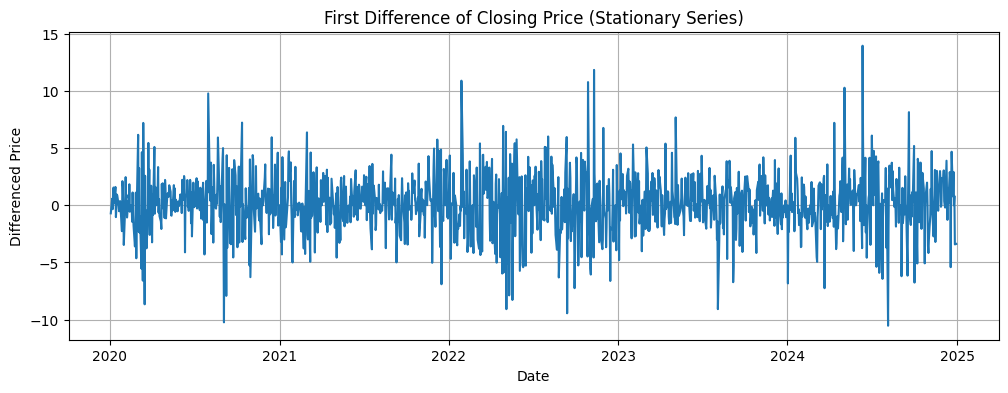

In [75]:
# First-order differencing
aapl['Close_diff'] = aapl['Close'].diff()

# Drop the first NaN value
aapl_diff = aapl['Close_diff'].dropna()

# Plot the differenced series
plt.figure(figsize=(12, 4))
plt.plot(aapl_diff)
plt.title("First Difference of Closing Price (Stationary Series)")
plt.xlabel("Date")
plt.ylabel("Differenced Price")
plt.grid(True)
plt.show()

In [76]:
result = adfuller(aapl_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -11.514834486222178
p-value: 4.174506318296742e-21


Plot ACF & PACF
To identify ARIMA parameters (p, d, q):

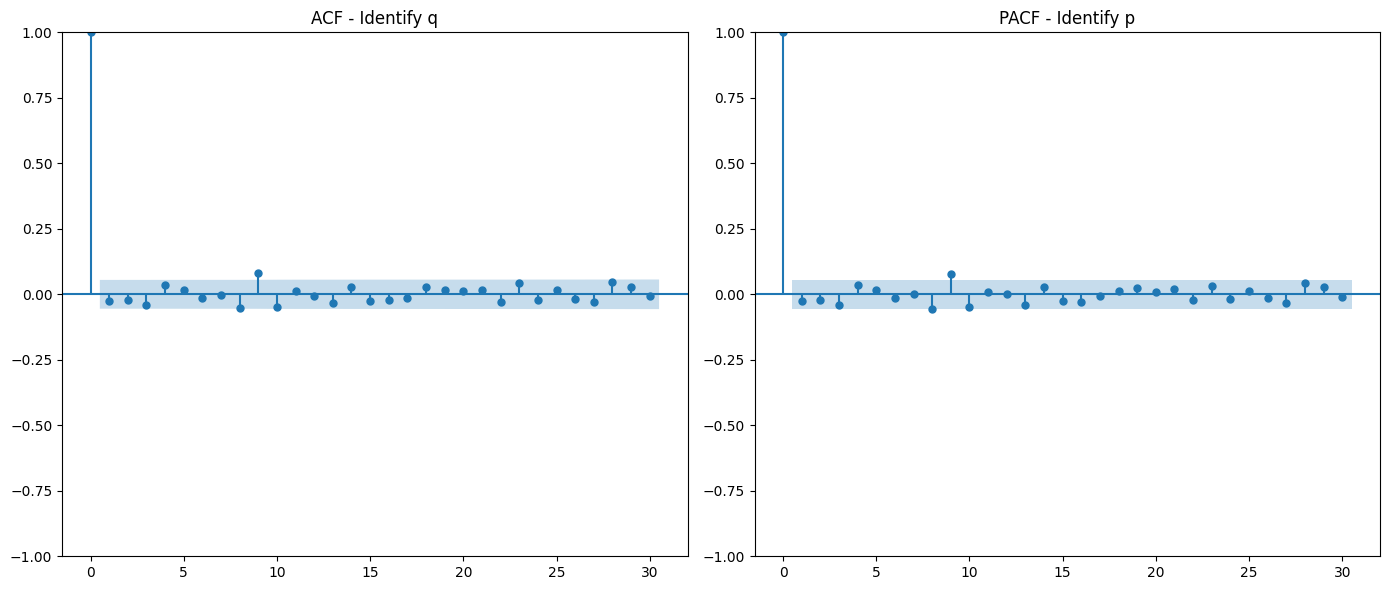

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_series = train['Close'].diff().dropna()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(diff_series, lags=30, ax=plt.gca())
plt.title('ACF - Identify q')

plt.subplot(1, 2, 2)
plot_pacf(diff_series, lags=30, ax=plt.gca(), method='ywm')
plt.title('PACF - Identify p')

plt.tight_layout()
plt.show()

Train/Test Split (30 Days for Test)

In [87]:
train = aapl['log_close'].dropna()[:-30]
test = aapl['log_close'].dropna()[-30:]

In [88]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model_arima = ARIMA(train, order=(1, 1, 2))
model_arima_fit = model_arima.fit()

# Forecast
forecast_log = model_arima_fit.forecast(steps=30)


In [89]:
# Convert back from log
forecast_arima = np.exp(forecast_log)
actual_close = np.exp(test)


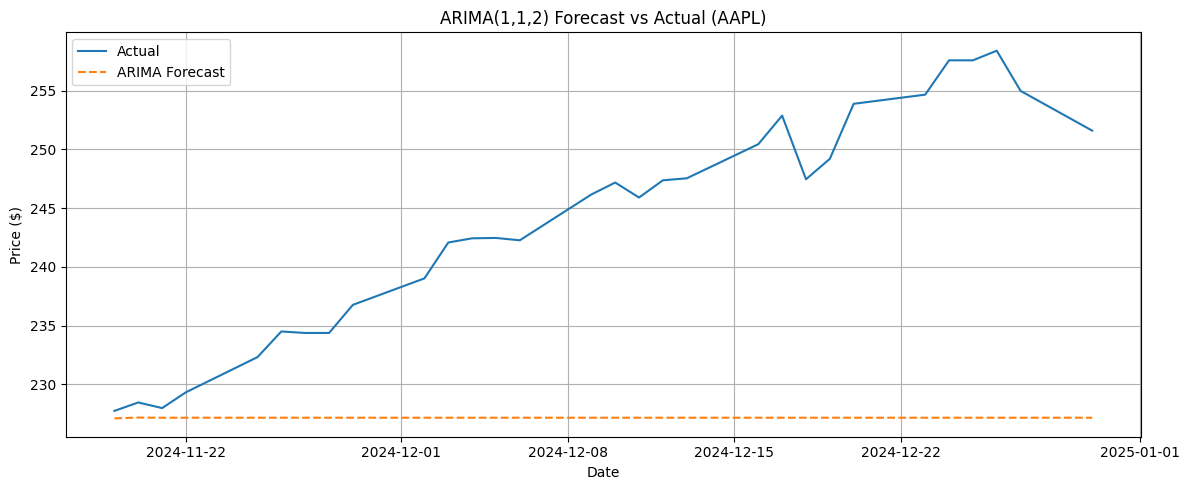

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(test.index, actual_close, label='Actual')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', linestyle='--')
plt.title("ARIMA(1,1,2) Forecast vs Actual (AAPL)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actual_close, forecast_arima)
rmse = np.sqrt(mean_squared_error(actual_close, forecast_arima))

print(f"ARIMA Evaluation:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}")


ARIMA Evaluation:
MAE: 16.74
RMSE: 19.20


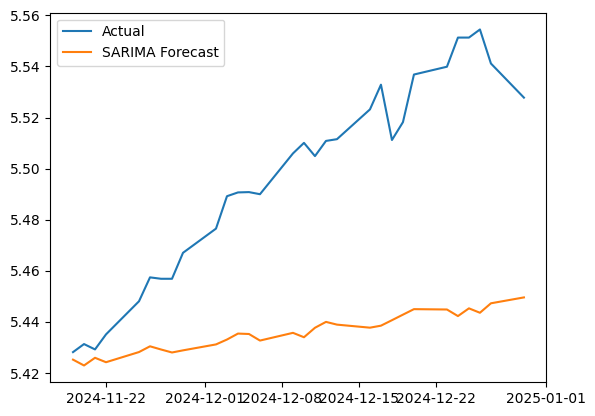

In [92]:
model_sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit()
forecast_sarima = model_sarima_fit.forecast(steps=30)

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast')
plt.legend()
plt.show()


In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual_sarima = test # Use test directly if it's not in log scale
forecast_sarima_exp = forecast_sarima # Use forecast_sarima directly if it's not in log scale


mae_sarima = mean_absolute_error(actual_sarima, forecast_sarima_exp)
rmse_sarima = np.sqrt(mean_squared_error(actual_sarima, forecast_sarima_exp))

print(f"SARIMA Evaluation (on log scale):\nMAE: {mae_sarima:.4f}\nRMSE: {rmse_sarima:.4f}")



SARIMA Evaluation (on log scale):
MAE: 0.0602
RMSE: 0.0681


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmc68jns3/1zt3641d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmc68jns3/i0xuy6xl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23739', 'data', 'file=/tmp/tmpmc68jns3/1zt3641d.json', 'init=/tmp/tmpmc68jns3/i0xuy6xl.json', 'output', 'file=/tmp/tmpmc68jns3/prophet_modeltdmzrwq5/prophet_model-20250807052232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:22:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:22:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


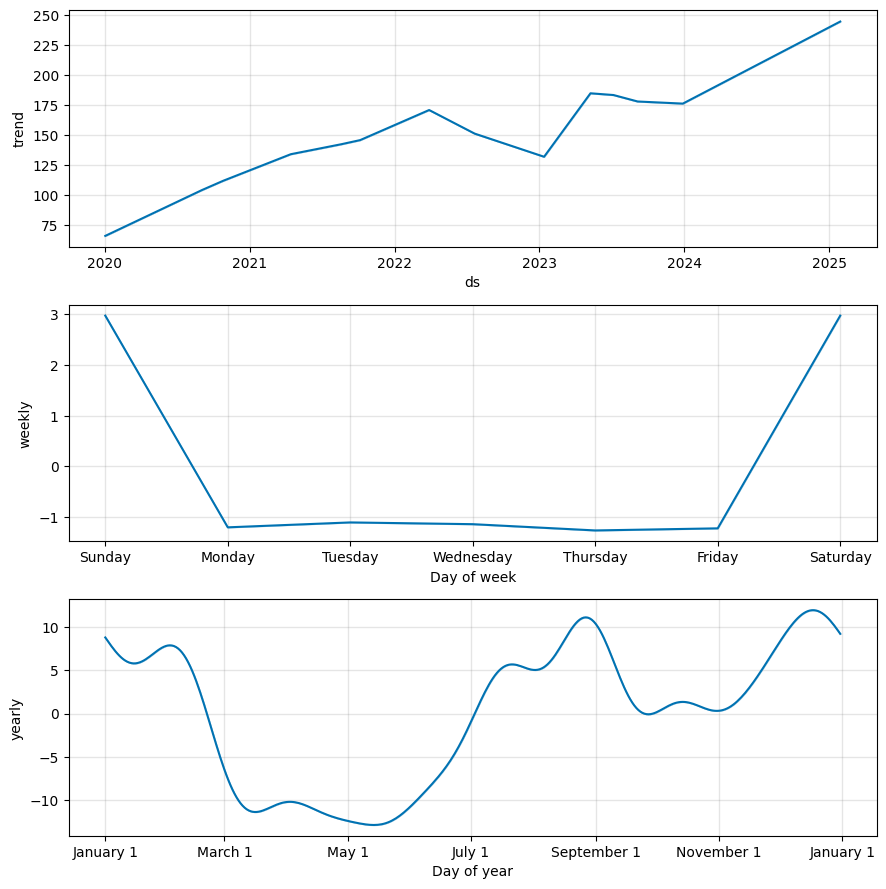

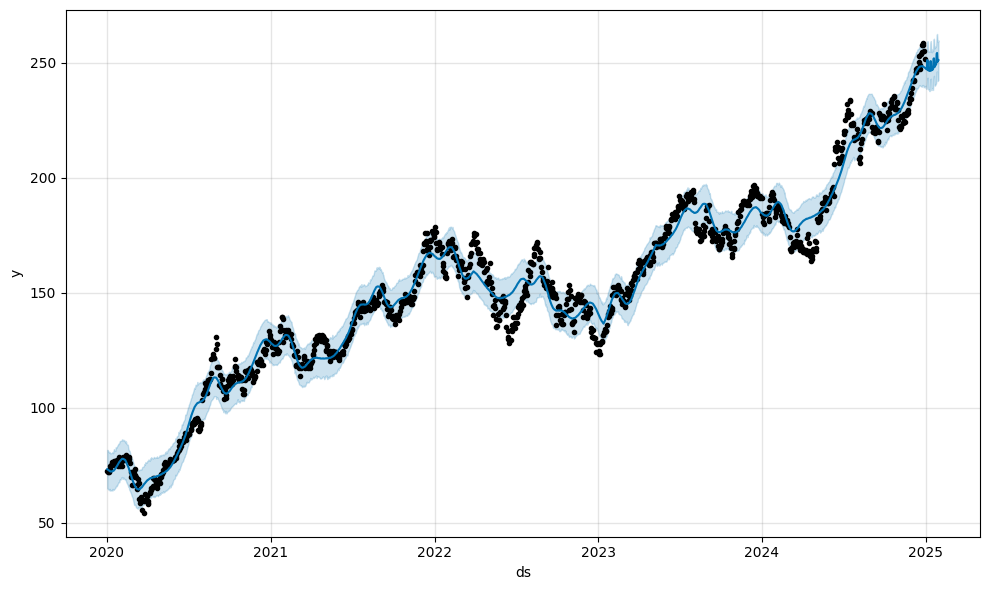

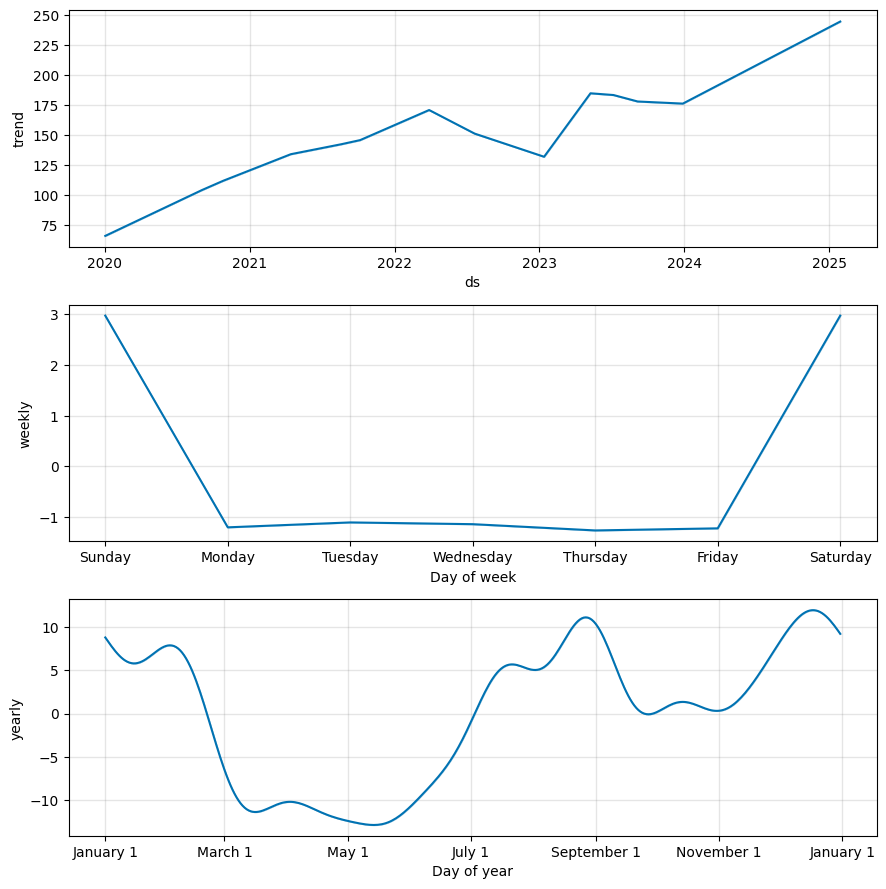

In [94]:
df_prophet = aapl.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

model_prophet.plot(forecast)
model_prophet.plot_components(forecast)

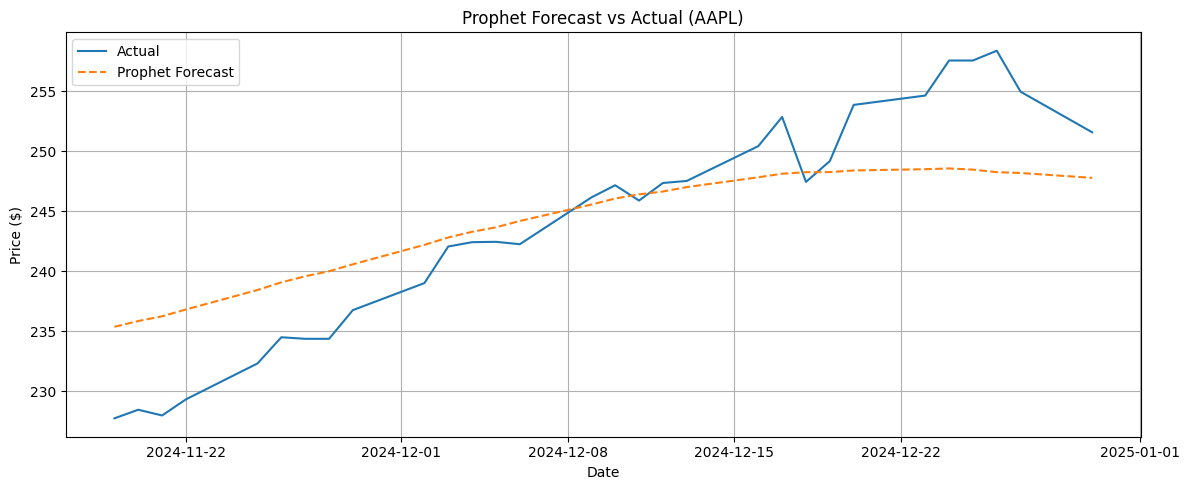

In [95]:
# Extract the forecast for the test period
forecast_test = forecast[forecast['ds'].isin(test.index)]

# Merge with actual values for plotting
prophet_plot_data = forecast_test[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Prophet Forecast'}).set_index('Date')
prophet_plot_data['Actual'] = actual_close # Use the actual_close variable from previous cells

# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(prophet_plot_data['Actual'], label='Actual')
plt.plot(prophet_plot_data['Prophet Forecast'], label='Prophet Forecast', linestyle='--')
plt.title("Prophet Forecast vs Actual (AAPL)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [96]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_prophet = mean_absolute_error(prophet_plot_data['Actual'], prophet_plot_data['Prophet Forecast'])
rmse_prophet = np.sqrt(mean_squared_error(prophet_plot_data['Actual'], prophet_plot_data['Prophet Forecast']))

print(f"Prophet Evaluation:\nMAE: {mae_prophet:.2f}\nRMSE: {rmse_prophet:.2f}")

Prophet Evaluation:
MAE: 4.24
RMSE: 5.21


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0445
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0017
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 9.1738e-04
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.6268e-04
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.3415e-04
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0011
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 8.0249e-04
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.7195e-04
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 7.0552e-04
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.0872e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


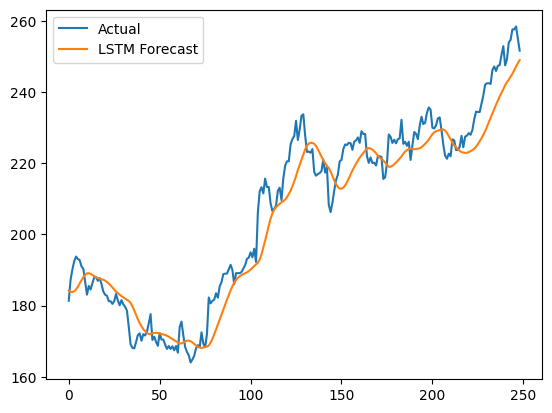

In [101]:
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(aapl[['Close']])

sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_close)):
    X.append(scaled_close[i-sequence_length:i])
    y.append(scaled_close[i])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split for training
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32)

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='LSTM Forecast')
plt.legend()
plt.show()

In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"LSTM Evaluation:\nMAE: {mae_lstm:.2f}\nRMSE: {rmse_lstm:.2f}")

LSTM Evaluation:
MAE: 5.51
RMSE: 6.83


Model Evaluation

In [104]:
def evaluate(true, pred, model_name=""):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

evaluate(test, forecast_arima, "ARIMA")
evaluate(test, forecast_sarima, "SARIMA")
evaluate(prophet_plot_data['Actual'], prophet_plot_data['Prophet Forecast'], "Prophet")
evaluate(y_test_inv, y_pred_inv, "LSTM")


ARIMA - MAE: 221.6524, RMSE: 221.6524
SARIMA - MAE: 0.0602, RMSE: 0.0681
Prophet - MAE: 4.2356, RMSE: 5.2099
LSTM - MAE: 5.5099, RMSE: 6.8276


In [107]:
results = pd.DataFrame({
    "Date": test.index,
    "Actual": test.values,
    "ARIMA_Predicted": forecast_arima.values
})
results.to_csv("arima_forecast.csv", index=False)


In [110]:
forecast[["ds", "yhat"]].to_csv("prophet_forecast.csv", index=False)

In [111]:
df_lstm = pd.DataFrame({
    "Date": aapl.index[-len(y_test_inv):],
    "Actual": y_test_inv.flatten(),
    "LSTM_Predicted": y_pred_inv.flatten()
})
df_lstm.to_csv("lstm_forecast.csv", index=False)